### Notes:
- **Perfomance Metric:**
- Net Profit/Loss (PnL)
- Average PnL per trade
- Total Return (Percentage and Number)
- Average Annual Return (for historical data)
- Risk-Adjusted Return
- Win Rate
- Average Profit/Loss per trade
- Maximum Drawdown
- Volatility (of returns)
- Trading Exposure
- Market Exposure
- Alpha
- Beta
- Sharpe Ratio
- trading fees **optional**

- **Data Sources:**
- IB TWS api Trades data gives total traded volume and high and lows for bar data

- **Process for Backtest:**
- have 3 lists: buys, sells, portfolio value (total sell val - buy vale)
- use 'close' data for buy and sell data (or maybe calculate midpoint with high - low)
- make buy, sell, and portfolio value into a np dataframe
- calculate stats from portfolio value

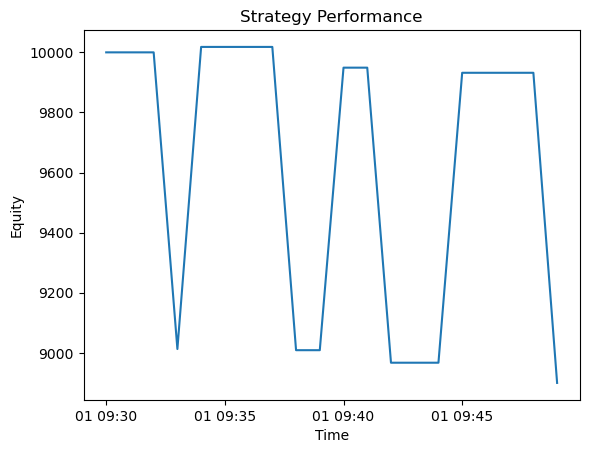

[10000, 10000, 10000, 9012.604606480154, 10018.085098559062, 10018.085098559062, 10018.085098559062, 10018.085098559062, 9008.70493726721, 9008.70493726721, 9949.06670664612, 9949.06670664612, 8967.008153996181, 8967.008153996181, 8967.008153996181, 9931.999202111683, 9931.999202111683, 9931.999202111683, 9931.999202111683, 8899.756826567045]
[10, 4, 3, 8899.756826567045]
[-987.3953935198462, -1009.3801612918517, -982.0585526499378, -1032.242375544639]
[1005.4804920789092, 940.3617693789097, 964.9910481155024]
                           high         low       close  volume  signals
time                                                                    
2030-01-01 09:30:00  104.841282   93.436548  102.206137    6734        0
2030-01-01 09:31:00  100.747561   89.079528   98.345649    4142       -1
2030-01-01 09:32:00  115.110586  111.632821  112.153856    4949        0
2030-01-01 09:33:00  100.320772   93.779400   98.739539    4793        1
2030-01-01 09:34:00  102.290146   90.724096  1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

time_index = pd.date_range(start = '2030-01-01 09:30', periods = 20, freq = 'min')

np.random.seed(5)
close = np.random.normal(loc = 100, scale = 5, size = 20)
high = close + np.random.uniform(0.5, 8, size = 20)
low = close - np.random.uniform(0.5, 10, size = 20)
volume = np.random.randint(2000, 8000, size = 20)

data = pd.DataFrame({
    'high':high,
    'low':low,
    'close':close,
    'volume':volume
}, index = time_index)

data.index.name = 'time'

#print(data.head(10))

# load data function -> yf only gives 1 week of 1 min bar data. Change in future for longer 1 min bar data with IB API

# Signal generation function
def generate_signal(df: pd.DataFrame):
    # Crossover signals (changes depending on strategy)
    buy_crossover_signals = (data['MACD_line'] > 0) & (data[f'{short_ema}-day EMA'] > data[f'{long_ema}-day EMA']) & \
                            (data['Full %K'] > data['Full %D']) & (data['Full %K'] > 0) & (data['Full %D'] > 0) & (data['chaikin oscillator'] > 0)

    sell_crossover_signals = (data[f'{short_ema}-day EMA'] < data[f'{long_ema}-day EMA']) & (data['Full %K'] < data['Full %D']) \
                             & (data['Full %K'] < 70) & (data['Full %D'] < 70) & (data['chaikin oscillator'] < 0)
    #-----------------------------------------------------------------------
    
    df['signals'] = 0
    df['signals'] = np.where((buy_crossover_signals & ~buy_crossover_signals.shift(1)), 1, df['signal'])
    df['signals'] = np.where((sell_crossover_signals & ~sell_crossover_signals.shift(1)), -1, df['signal'])
    return df

#-------------------
num = [0, 1, -1]
signal = np.random.choice(num, 20)
data['signals'] = signal
#print(data.head(25))
#-------------------

# Strategy execution function
def execute_strategy(df: pd.DataFrame, init_equity: float, buy_size: int, sell_size: int):
    '''
    '''
    # initialize variables
    positions = 0
    number_buys = 0
    number_sells = 0 # add both number of buys and sells to get number of trades
    equity_value = init_equity
    portfolio = []
    buys = []
    sells = []
    dates = []
    
    for row in df.itertuples(index = True):
        if row.signals == 1:
            positions += buy_size
            number_buys += 1
            buy_position = -(row.close*buy_size)
            equity_value += buy_position
            portfolio.append(equity_value)
            buys.append(buy_position)
            dates.append(row.Index)
            
        elif (row.signals == -1) and (positions > 0):
            positions -= sell_size
            number_sells += 1
            sell_position = row.close*sell_size
            equity_value += sell_position
            portfolio.append(equity_value)
            sells.append(sell_position)
            dates.append(row.Index)

        else: # row.signal == 0
            portfolio.append(equity_value)
            dates.append(row.Index)

    info = [positions, number_buys, number_sells, equity_value]
    plt.plot(dates, portfolio)
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.title('Strategy Performance')
    plt.show()

    print(portfolio)
    print(info)
    print(buys)
    print(sells)
    print(data)
    # trades_data = pd.DataFrame(
    #     {'performance':portfolio,
    #      'buys':buys,
    #      'sells':sells,})
    return portfolio, buys, sells

execute_strategy(data, 10000, 10, 10)

# Calculate Backtest Results Function
def backtest_results(init_equity: float, trade_info: tuple): # df contains trading performance, buys, and sells column
    # organize df series into separate series
    performance = pd.Series(trade_info[0])
    buys_data = pd.Series(trade_info[1])
    sells_data = pd.Series(trade_info[2])

    # number stats of trades
    number_buys = len(buys_data)
    number_sells = len(sells_data)
    number_trades = number_buys + number_sells

    # calculate max drawdown
    running_max = performance.cummax()
    drawdown = (performance - running_max) / running_max
    max_drawdown = drawdown.min()

    
    #-----------------#
    # Performance Stats
    #-----------------#

    # Net PnL
    net_pnl = performance[-1] - init_equity # edit later to account for fees
    
    # per trade stats:
    if number_buys < number_sells:
        fixed_buys_data = buys_data[:number_sells]
        trade_results = sells_data - fixed_buys_data
        # average PnL per trade
        avg_pnl_per_trade = trades_results.mean() # edit later to add fees and commission
        # Win Rate
        wins = len(trade_results[trade_results > 0])
        total_trades = len(trade_results)
        win_rate = wins/total_trades

        
    else: # buys > sells
        fixed_sells_data = sells_data[:number_buys]
        trade_results = fixed_sells_data - buys_data
        

    
# - **Perfomance Metric:**
# - Net Profit/Loss (PnL)
# - Average PnL per trade
# - Total Return (Percentage and Number)
# - Average Annual Return (for historical data)
# - Risk-Adjusted Return
# - Win Rate
# - Average Profit/Loss per trade
# - Maximum Drawdown
# - Volatility (of returns)
# - Trading Exposure
# - Market Exposure
# - Alpha
# - Beta
# - Sharpe Ratio
# - trading fees **optional**

# - annualized return, trading frequency
# talib, yfinance

Matplotlib is building the font cache; this may take a moment.


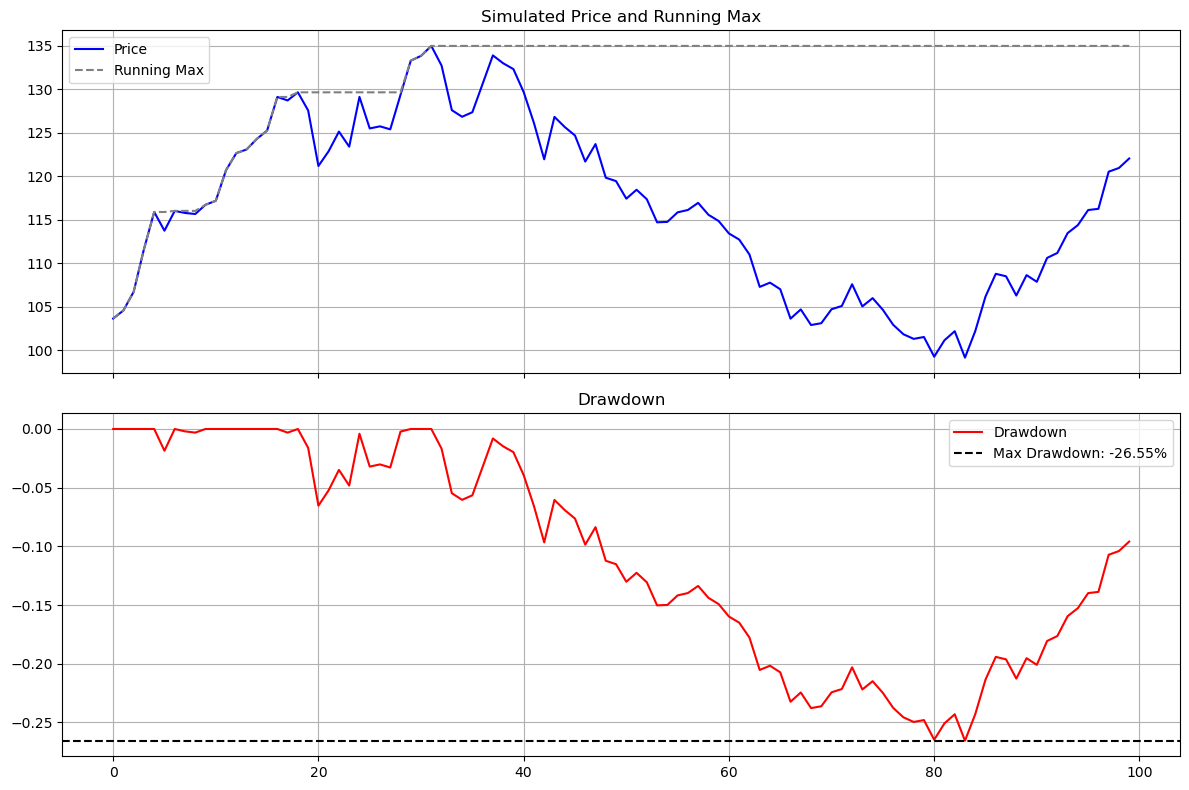

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulate closing prices
np.random.seed(0)
returns = np.random.normal(loc=0.001, scale=0.02, size=100)
price = 100 * (1 + pd.Series(returns)).cumprod()

# Calculate running max
running_max = price.cummax()

# Calculate drawdown
drawdown = (price - running_max) / running_max
max_drawdown = drawdown.min()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot price
ax1.plot(price, label='Price', color='blue')
ax1.plot(running_max, label='Running Max', linestyle='--', color='gray')
ax1.set_title('Simulated Price and Running Max')
ax1.legend()
ax1.grid(True)

# Plot drawdown
ax2.plot(drawdown, label='Drawdown', color='red')
ax2.axhline(max_drawdown, color='black', linestyle='--', label=f'Max Drawdown: {max_drawdown:.2%}')
ax2.set_title('Drawdown')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

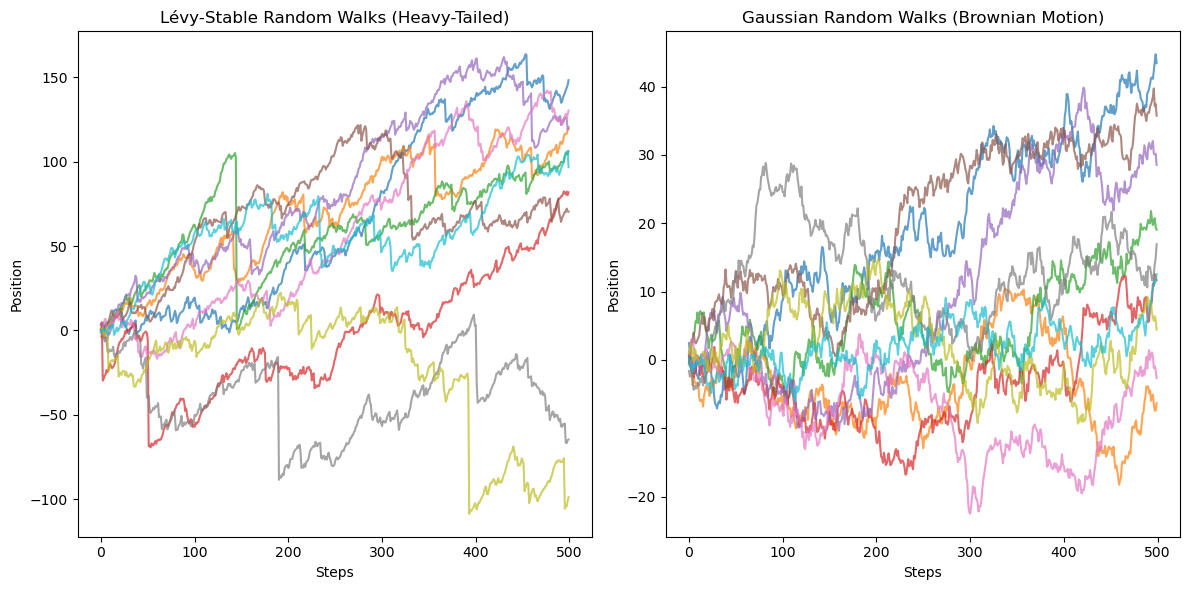

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

# Simulation parameters
num_simulations = 100
num_steps = 500  # Length of each random walk

# Lévy-Stable Distribution Parameters
alpha_levy = 1.5  # Stability parameter (heavy-tailed behavior)
beta_levy = -1    # Symmetric Lévy distribution
scale_levy = 1    # Scale parameter (step size)
loc_levy = 0      # Centered at 0

# Gaussian (Normal) Distribution Parameters
mean_gauss = 0    # Mean of step size
std_gauss = 1     # Standard deviation (similar to scale of Levy)

# Generate 100 Lévy-stable random walks
levy_walks = np.cumsum(levy_stable.rvs(alpha_levy, beta_levy, loc=loc_levy, scale=scale_levy,
                                       size=(num_simulations, num_steps)), axis=1)

# Generate 100 Gaussian (Brownian motion) random walks
gauss_walks = np.cumsum(np.random.normal(mean_gauss, std_gauss, size=(num_simulations, num_steps)), axis=1)

# Plotting comparison of Lévy and Gaussian walks
plt.figure(figsize=(12, 6))

# Plot Lévy Walks
plt.subplot(1, 2, 1)
for i in range(10):  # Plot only 10 for clarity
    plt.plot(levy_walks[i], alpha=0.7)
plt.title("Lévy-Stable Random Walks (Heavy-Tailed)")
plt.xlabel("Steps")
plt.ylabel("Position")

# Plot Gaussian Walks
plt.subplot(1, 2, 2)
for i in range(10):  # Plot only 10 for clarity
    plt.plot(gauss_walks[i], alpha=0.7)
plt.title("Gaussian Random Walks (Brownian Motion)")
plt.xlabel("Steps")
plt.ylabel("Position")

plt.tight_layout()
plt.show()